[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1mUDx4uFpbS6jrD7lN-P7F7saefP_QJ31?usp=sharing)


In [1]:
# Import required packages
!python -m spacy download fr_core_news_sm
#import fr_core_news_sm
import spacy
from spacy import displacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
 

     |████████████████████████████████| 14.7 MB 520 kB/s 
  Created wheel for fr-core-news-sm: filename=fr_core_news_sm-2.2.5-py3-none-any.whl size=14727026 sha256=2a5abd0603f98731f6f129668ee43e7ca6fc7753e6bfb45b6760bfe803c46d0d
  Stored in directory: /tmp/pip-ephem-wheel-cache-p92bszlh/wheels/c9/a6/ea/0778337c34660027ee67ef3a91fb9d3600b76777a912ea1c24
Successfully built fr-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_sm')


In [2]:
# Import additional packages
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from spacy.lang.fr.stop_words import STOP_WORDS
from spacy.lang.fr.examples import sentences 
from spacy.lang.fr import French


In [61]:
path = "https://raw.githubusercontent.com/Lirette2/DMML2021_Apple/main/data/training_data.csv"

df = pd.read_csv(path, index_col=0)
df.head()


,sentence
id,
0,Nous dûmes nous excuser des propos que nous eû...
1,Vous ne pouvez pas savoir le plaisir que j'ai ...
2,"Et, paradoxalement, boire froid n'est pas la b..."
3,"Ce n'est pas étonnant, car c'est une saison my..."
4,"Le corps de Golo lui-même, d'une essence aussi..."


In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4800 entries, 0 to 4799
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   sentence    4800 non-null   object
 1   difficulty  4800 non-null   object
dtypes: object(2)
memory usage: 112.5+ KB


In [5]:
# Base rate: the data-set is a bit balanced!
df.difficulty.value_counts()


A1    813
C2    807
C1    798
B1    795
A2    795
B2    792
Name: difficulty, dtype: int64

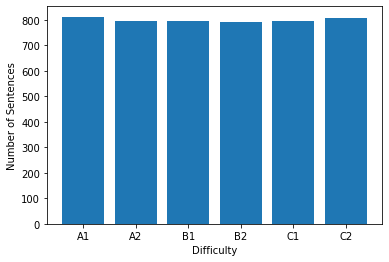

In [6]:
difficulty_count = df.groupby("difficulty").count()
plt.bar(difficulty_count.index.values, difficulty_count["sentence"])
plt.xlabel("Difficulty")
plt.ylabel("Number of Sentences")
plt.show()

In [7]:
round(df.difficulty.value_counts().max()/ len(df), 4)


0.1694

### tokening the date with spaCy


In [8]:
# Create a list of punctuation marks
punctuations = string.punctuation
punctuations

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [9]:
# Create a list of stopwords
#stop_words = spacy.lang.en.stop_words.STOP_WORDS
stop_words = spacy.lang.fr.stop_words.STOP_WORDS

list(stop_words)[:10]

['seulement',
 'pu',
 'pourquoi',
 'minimale',
 'anterieur',
 'certaine',
 'chères',
 'seul',
 'houp',
 'tel']

In [10]:
# Load French language model
import fr_core_news_sm
#sp = spacy.load('en_core_web_sm')
sp = fr_core_news_sm.load()

# Create tokenizer function
def spacy_tokenizer(sentence):
    # Create token object, which is used to create documents with linguistic annotations.
    mytokens = sp(sentence)

    # Lemmatize each token and convert each token into lowercase
    mytokens = [ word.lemma_.lower().strip() for word in mytokens ]
    ## alternative way
    # mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Remove stop words and punctuation
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # Return preprocessed list of tokens
    return mytokens



In [11]:
# Example
#New_sentence = df["sentence"].sample()
New_sentence = df["sentence"].head()
New_sentence.values[0]
spacy_tokenizer(New_sentence.values[0])


['coût',
 'kilométrique',
 'réel',
 'pouvoir',
 'diverger',
 'sensiblemer',
 'valeur',
 'moyenner',
 'fonction',
 'moyen',
 'transport',
 'utiliser',
 'taux',
 'occupation',
 'taux',
 'remplissage',
 'infrastructure',
 'utiliser',
 'topographie',
 'ligne',
 'flux',
 'trafic',
 'etc.']

In [12]:
#### **** ***************** **** ####
#### **** RAW TEXT FEATURES **** ####
#### **** ***************** **** ####

# Count tokens per sentence
def count_token(sent):
  return(len(spacy_tokenizer(sent))) #spacy_tokenizer() to get tokens, len() to count them

# Count raw words per sentence
def count_words(sent):
  return(len(sent.split())) #split() gives us individual words, len() counts them

#Get average character length of word
def count_avg_word_character(sent):
  words = sent.split()
  return(sum(len(word) for word in words) / len(words))

def count_avg_token_character(sent):
  words = spacy_tokenizer(sent)
  if len(words) == 0:
    return(0)
  else:
    return(sum(len(word) for word in words) / len(words))

In [13]:
#### **** **************** **** ####
#### **** LEXICAL FEATURES **** ####
#### **** **************** **** ####

# Lexical Diversity
def lex_div_word(sent):
  total_number_word = len(sent.split())
  unique = set(sent.split())
  return(len(unique)/total_number_word)
#We don't apply for token, as the goal of the tokenzization is to be left with 
#unique tokens
#For tokens, we should apply to the whole text as done by tfidf_vector

# Lexical Density
def lex_den_tokens(sent):
  st = spacy_tokenizer(sent)
  if len(st) == 0:
    return(0)
  else:
    string = " ".join([str(item) for item in st])
    x = sp(string)
    counter = 0 
    for token in x:
      if token.pos_ == "NOUN" or token.pos_ == "ADJ" or token.pos_ == "VERB" or token.pos_ == "ADV":
        counter = counter + 1
    return(counter/len(st))

def lex_den_words(sent):
  x = sp(sent)
  counter = 0 
  for token in x:
    if token.pos_ == "NOUN" or token.pos_ == "ADJ" or token.pos_ == "VERB" or token.pos_ == "ADV":
      counter = counter + 1
  return(counter/len(x))

# Words NOT in frequent list
path = "https://raw.githubusercontent.com/Lirette2/DMML2021_Apple/main/data/list_words.csv"
words = pd.read_csv(path, index_col=0)


def words_list(sent):
  unique = set(sent.split())
  counter = 0
  for word_in_sentence in unique:
    for word_in_list in words.Mots:
      if word_in_sentence == word_in_list:
        counter = counter + 1
        break#we stop comparing once the word in found, to make it faster
  return(1-(counter/len(unique)))


def token_list(sent):
  unique = spacy_tokenizer(sent)
  if len(unique) == 0:
    return(0)
  else:
    counter = 0
    for word_in_sentence in unique:
      for word_in_list in words.Mots:
        if word_in_sentence == word_in_list:
          counter = counter + 1
          break#we stop comparing once the word in found, to make it faster
    return(1-(counter/len(unique)))


In [14]:
raw_word_count = pd.Series(df.sentence.apply(count_words),name="raw_word_count")
token_count = pd.Series(df.sentence.apply(count_token),name="token_count")
avg_chr_word = pd.Series(df.sentence.apply(count_avg_word_character),name="avg_chr_word")
avg_chr_token = pd.Series(df.sentence.apply(count_avg_token_character),name="avg_chr_token")
diversity_word = pd.Series(df.sentence.apply(lex_div_word),name="diversity_word")
density_word = pd.Series(df.sentence.apply(lex_den_words),name="density_word")
density_token = pd.Series(df.sentence.apply(lex_den_tokens),name="density_token")
freq_word_list = pd.Series(df.sentence.apply(words_list),name="freq_word_list")
freq_token_list = pd.Series(df.sentence.apply(token_list),name="freq_token_list")

new_df = pd.concat([df,raw_word_count,token_count,avg_chr_word,avg_chr_token,
                    diversity_word,density_word,density_token,freq_word_list,freq_token_list],axis=1)
new_df

,sentence,difficulty,raw_word_count,token_count,avg_chr_word,avg_chr_token,diversity_word,density_word,density_token,freq_word_list,freq_token_list
id,,,,,,,,,,,
0,Les coûts kilométriques réels peuvent diverger...,C1,38,23,5.736842,7.434783,0.763158,0.488889,0.956522,0.793103,0.739130
1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1,12,5,4.250000,5.400000,1.000000,0.375000,0.400000,0.583333,0.200000
2,Le test de niveau en français est sur le site ...,A1,13,6,4.153846,5.833333,0.923077,0.400000,1.000000,0.500000,0.666667
3,Est-ce que ton mari est aussi de Boston?,A1,8,2,4.125000,5.000000,1.000000,0.400000,0.500000,0.250000,0.500000
4,"Dans les écoles de commerce, dans les couloirs...",B1,34,18,5.176471,5.611111,0.823529,0.380952,0.722222,0.714286,0.500000
...,...,...,...,...,...,...,...,...,...,...,...
4795,"C'est pourquoi, il décida de remplacer les hab...",B2,26,12,5.384615,7.500000,1.000000,0.500000,0.833333,0.576923,0.416667
4796,Il avait une de ces pâleurs splendides qui don...,C1,21,10,4.666667,5.700000,0.952381,0.454545,1.000000,0.750000,0.600000
4797,"Et le premier samedi de chaque mois, venez ren...",A2,14,6,4.785714,6.666667,0.928571,0.466667,1.000000,0.538462,0.333333


In [15]:
#Scale the data
scaler = MinMaxScaler()
col_to_scale = ["raw_word_count","token_count","avg_chr_word","avg_chr_token"]
#no need for the others because they already are on a scale from 0 to 1
new_df[col_to_scale]= scaler.fit_transform(new_df[col_to_scale])

new_df 

,sentence,difficulty,raw_word_count,token_count,avg_chr_word,avg_chr_token,diversity_word,density_word,density_token,freq_word_list,freq_token_list
id,,,,,,,,,,,
0,Les coûts kilométriques réels peuvent diverger...,C1,0.140152,0.184,0.339713,0.619565,0.763158,0.488889,0.956522,0.793103,0.739130
1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1,0.041667,0.040,0.204545,0.450000,1.000000,0.375000,0.400000,0.583333,0.200000
2,Le test de niveau en français est sur le site ...,A1,0.045455,0.048,0.195804,0.486111,0.923077,0.400000,1.000000,0.500000,0.666667
3,Est-ce que ton mari est aussi de Boston?,A1,0.026515,0.016,0.193182,0.416667,1.000000,0.400000,0.500000,0.250000,0.500000
4,"Dans les écoles de commerce, dans les couloirs...",B1,0.125000,0.144,0.288770,0.467593,0.823529,0.380952,0.722222,0.714286,0.500000
...,...,...,...,...,...,...,...,...,...,...,...
4795,"C'est pourquoi, il décida de remplacer les hab...",B2,0.094697,0.096,0.307692,0.625000,1.000000,0.500000,0.833333,0.576923,0.416667
4796,Il avait une de ces pâleurs splendides qui don...,C1,0.075758,0.080,0.242424,0.475000,0.952381,0.454545,1.000000,0.750000,0.600000
4797,"Et le premier samedi de chaque mois, venez ren...",A2,0.049242,0.048,0.253247,0.555556,0.928571,0.466667,1.000000,0.538462,0.333333


## classification of level using logistic regression

In [58]:
# Select features
X = new_df[["sentence","raw_word_count","token_count","avg_chr_word","avg_chr_token",
                    "diversity_word","density_word","density_token","freq_word_list",
            "freq_token_list"]]# the features we want to analyze

ylabels = new_df['difficulty'] # the labels, or answers, we want to test against

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.2, random_state=1234, stratify=ylabels)

X_train

,sentence,raw_word_count,token_count,avg_chr_word,avg_chr_token,diversity_word,density_word,density_token,freq_word_list,freq_token_list
id,,,,,,,,,,
962,Le réalisateur m'a d'abord demandé de me mettr...,0.037879,0.032,0.272727,0.645833,1.000000,0.428571,1.000000,0.545455,0.500000
1886,"Après quelques mois de cette pauvreté noble, a...",0.109848,0.112,0.266667,0.517857,0.966667,0.352941,0.714286,0.586207,0.714286
2721,L'indicateur n'était que de 40% chez les femme...,0.034091,0.040,0.245455,0.483333,1.000000,0.357143,0.600000,0.600000,0.800000
1025,L'objectif de ce type de voyage est d'être act...,0.094697,0.096,0.241259,0.527778,0.923077,0.482759,1.000000,0.375000,0.416667
4048,"Et, en France, beaucoup moins de filles que de...",0.083333,0.080,0.276680,0.500000,0.956522,0.384615,0.500000,0.636364,0.300000
...,...,...,...,...,...,...,...,...,...,...
3693,Je vais prendre ma douche dans ma salle-de-bain.,0.026515,0.032,0.284091,0.645833,0.875000,0.333333,0.750000,0.714286,0.500000
3408,"Après l'éruption de 1754, la plus grosse connu...",0.132576,0.128,0.275253,0.546875,0.805556,0.380952,0.625000,0.655172,0.625000
4289,Léonard est initié par Verrocchio aux nombreus...,0.117424,0.120,0.369318,0.644444,0.937500,0.472222,0.866667,0.666667,0.866667


In [17]:
y_train


id
962     B1
1886    C1
2721    A2
1025    B1
4048    B2
        ..
3693    A1
3408    B1
4289    C2
3312    C2
269     A1
Name: difficulty, Length: 3840, dtype: object

In [19]:
# Evaluate the model
def evaluate(test, pred):
  precision = precision_score(test, pred,average=None)
  recall = recall_score(test, pred, average=None)
  f1= f1_score(test, pred, average=None)
  print(f'CONFUSION MATRIX:\n{confusion_matrix(test, pred)}')
  print(f"ACCURACY SCORE:\n{accuracy_score(test, pred) :.4f}")
  print(f'CLASSIFICATION REPORT:')
  print("Precision:\t {0:4f}".format(precision_score(test, pred,average="macro"))) 
  print("Recall:\t {0:4f}".format(recall_score(test, pred, average="macro")))
  print("F1_Score:\t {0:4f}".format(f1_score(test, pred, average="macro")))


In [59]:
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report

# Define classifier
classifier = LogisticRegression(multi_class="multinomial",max_iter=1000)

#Vectorizer
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer)

#Column Transformer (to apply vectorizer to the right column)
column_transformer = ColumnTransformer(
    [("tfidf", tfidf_vector, "sentence")],
    remainder="passthrough")

# Create pipeline
pipe = Pipeline([("tfidf",column_transformer),("classifier", classifier)])

# Fit model on training set
pipe.fit(X_train, y_train)
# Predictions
y_pred = pipe.predict(X_test)

# Evaluation - test set
evaluate(y_test, y_pred)

#just token: 0.4531
#just words: 0.4729
#everything: 0.4823

CONFUSION MATRIX:
[[101  27  24   8   3   0]
 [ 43  60  41   7   8   0]
 [ 20  41  62  21   5  10]
 [  4   8  13  73  31  29]
 [  3   2  11  34  77  33]
 [  3   0  13  24  31  90]]
ACCURACY SCORE:
0.4823
CLASSIFICATION REPORT:
Precision:	 0.480458
Recall:	 0.481535
F1_Score:	 0.480457


In [62]:
### Submission data

path = "https://raw.githubusercontent.com/Lirette2/DMML2021_Apple/main/data/unlabelled_test_data.csv"
sub_df = pd.read_csv(path, index_col=0)

raw_word_count = pd.Series(sub_df.sentence.apply(count_words),name="raw_word_count")
token_count = pd.Series(sub_df.sentence.apply(count_token),name="token_count")
avg_chr_word = pd.Series(sub_df.sentence.apply(count_avg_word_character),name="avg_chr_word")
avg_chr_token = pd.Series(sub_df.sentence.apply(count_avg_token_character),name="avg_chr_token")
diversity_word = pd.Series(sub_df.sentence.apply(lex_div_word),name="diversity_word")
density_word = pd.Series(sub_df.sentence.apply(lex_den_words),name="density_word")
density_token = pd.Series(sub_df.sentence.apply(lex_den_tokens),name="density_token")
freq_word_list = pd.Series(sub_df.sentence.apply(words_list),name="freq_word_list")
freq_token_list = pd.Series(sub_df.sentence.apply(token_list),name="freq_token_list")

new_sub_df = pd.concat([sub_df,raw_word_count,token_count,avg_chr_word,avg_chr_token,
                    diversity_word,density_word,density_token,freq_word_list,freq_token_list],axis=1)
new_sub_df

,sentence,raw_word_count,token_count,avg_chr_word,avg_chr_token,diversity_word,density_word,density_token,freq_word_list,freq_token_list
id,,,,,,,,,,
0,Nous dûmes nous excuser des propos que nous eû...,10,4,5.000000,7.000000,0.900000,0.300000,0.750000,0.666667,0.250000
1,Vous ne pouvez pas savoir le plaisir que j'ai ...,14,5,4.714286,6.200000,1.000000,0.437500,0.800000,0.428571,0.000000
2,"Et, paradoxalement, boire froid n'est pas la b...",9,5,5.555556,6.600000,1.000000,0.538462,0.800000,0.666667,0.400000
3,"Ce n'est pas étonnant, car c'est une saison my...",9,3,5.222222,8.000000,1.000000,0.416667,1.000000,0.666667,0.666667
4,"Le corps de Golo lui-même, d'une essence aussi...",72,31,5.402778,7.322581,0.791667,0.418605,0.612903,0.543860,0.677419
...,...,...,...,...,...,...,...,...,...,...
1195,C'est un phénomène qui trouve une accélération...,22,9,5.090909,8.000000,0.954545,0.423077,1.000000,0.619048,0.555556
1196,Je vais parler au serveur et voir si on peut d...,13,6,4.076923,6.000000,1.000000,0.428571,0.833333,0.538462,0.333333
1197,Il n'était pas comme tant de gens qui par pare...,75,34,5.266667,7.117647,0.826667,0.409091,0.852941,0.596774,0.441176


In [64]:
#Scale the submission data
scaler = MinMaxScaler()
col_to_scale = ["raw_word_count","token_count","avg_chr_word","avg_chr_token"]
#no need for the others because they already are on a scale from 0 to 1
new_sub_df[col_to_scale]= scaler.fit_transform(new_sub_df[col_to_scale])

new_sub_df 

,sentence,raw_word_count,token_count,avg_chr_word,avg_chr_token,diversity_word,density_word,density_token,freq_word_list,freq_token_list
id,,,,,,,,,,
0,Nous dûmes nous excuser des propos que nous eû...,0.051282,0.061538,0.413793,0.608696,0.900000,0.300000,0.750000,0.666667,0.250000
1,Vous ne pouvez pas savoir le plaisir que j'ai ...,0.076923,0.076923,0.374384,0.539130,1.000000,0.437500,0.800000,0.428571,0.000000
2,"Et, paradoxalement, boire froid n'est pas la b...",0.044872,0.076923,0.490421,0.573913,1.000000,0.538462,0.800000,0.666667,0.400000
3,"Ce n'est pas étonnant, car c'est une saison my...",0.044872,0.046154,0.444444,0.695652,1.000000,0.416667,1.000000,0.666667,0.666667
4,"Le corps de Golo lui-même, d'une essence aussi...",0.448718,0.476923,0.469349,0.636746,0.791667,0.418605,0.612903,0.543860,0.677419
...,...,...,...,...,...,...,...,...,...,...
1195,C'est un phénomène qui trouve une accélération...,0.128205,0.138462,0.426332,0.695652,0.954545,0.423077,1.000000,0.619048,0.555556
1196,Je vais parler au serveur et voir si on peut d...,0.070513,0.092308,0.286472,0.521739,1.000000,0.428571,0.833333,0.538462,0.333333
1197,Il n'était pas comme tant de gens qui par pare...,0.467949,0.523077,0.450575,0.618926,0.826667,0.409091,0.852941,0.596774,0.441176


In [97]:
# Get it in correct form and predict
X_sub = new_sub_df[["sentence","raw_word_count","token_count","avg_chr_word","avg_chr_token",
                    "diversity_word","density_word","density_token","freq_word_list",
            "freq_token_list"]]

y_sub_lsvc = pipe_lsvc.predict(X_sub)


In [98]:
new_sub_df["difficulty"] = y_sub_lsvc
submission = new_sub_df.filter(["id","difficulty"],axis=1)
submission

,difficulty
id,
0,C1
1,B1
2,C2
3,C1
4,C2
...,...
1195,C2
1196,A2
1197,C2


In [99]:
from google.colab import files
submission.to_csv('submission_05_apple_unil.csv') 
files.download('submission_05_apple_unil.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [75]:
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report

# Define classifier
classifier_CV = LogisticRegressionCV(solver='lbfgs', cv=5, max_iter=10000, random_state=72)

#Vectorizer
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer)

#Column Transformer (to apply vectorizer to the right column)
column_transformer = ColumnTransformer(
    [("tfidf", tfidf_vector, "sentence")],
    remainder="passthrough")

# Create pipeline
pipe_cv = Pipeline([("tfidf",column_transformer),("classifier", classifier_CV)])

# Fit model on training set
pipe_cv.fit(X_train, y_train)
# Predictions
#y_pred = pipe_cv.predict(X_test)

# Evaluation - test set
#evaluate(y_test, y_pred)

#just token: 
#just words: 0.4792
#everything: 0.4865, the time it takes to compute isn't worth it. 

Pipeline(steps=[('tfidf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tfidf',
                                                  TfidfVectorizer(tokenizer=<function spacy_tokenizer at 0x7f5a3554b9e0>),
                                                  'sentence')])),
                ('classifier',
                 LogisticRegressionCV(cv=5, max_iter=10000, random_state=72))])

In [86]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
#Create a Gaussian Classifier
random_for=RandomForestClassifier(n_estimators=100)

pipe_rf = Pipeline([("tfidf",column_transformer),('feature_selection',SelectFromModel(LinearSVC(penalty="l2"))),("model", random_for)])
#Train the model using the training sets y_pred=clf.predict(X_test)
pipe_rf.fit(X_train,y_train)

#y_pred=pipe.predict(X_test)
#evaluate(y_test, y_pred)

#just tokens:0.4365
#just words: 0.4688

Pipeline(steps=[('tfidf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tfidf',
                                                  TfidfVectorizer(tokenizer=<function spacy_tokenizer at 0x7f5a3554b9e0>),
                                                  'sentence')])),
                ('feature_selection', SelectFromModel(estimator=LinearSVC())),
                ('model', RandomForestClassifier())])

In [100]:
from sklearn.svm import LinearSVC


#Train the model
lsvc = LinearSVC(verbose=0)

pipe_lsvc = Pipeline([("tfidf",column_transformer),("model", lsvc)])
pipe_lsvc.fit(X_train,y_train)
y_pred=pipe.predict(X_test)
evaluate(y_test, y_pred)
#just token: 0.4344
#just words: 0.4458
#everything with no feature selection: 0.4865
#everything with feature selection: 0.4865
#but when doing the submission, it's lower....overfitting!

CONFUSION MATRIX:
[[99 31 24  8  1  0]
 [40 66 42  6  5  0]
 [24 39 61 21  6  8]
 [ 5  6 18 73 28 28]
 [ 2  3  6 36 84 29]
 [ 5  0 12 28 32 84]]
ACCURACY SCORE:
0.4865
CLASSIFICATION REPORT:
Precision:	 0.486960
Recall:	 0.485811
F1_Score:	 0.485816
